In [ ]:
# definitions for pre-processing the data
import pandas as pd
import datetime 
import numpy as np
# global constants --------------------------------------------------------------------------------
g_data_path = "IVE_tickbidask.txt"
g_interesting_window_start = datetime.time(15, 30, 0)
g_interesting_window_end = datetime.time(16, 0, 0)
g_normalize = True;
# -------------------------------------------------------------------------------------------------

def convert_time(string_time):
    # given a time in string format, output a time in datetime.time format
    format = "%H:%M:%S"
    output = datetime.datetime.strptime(string_time, format)
    return output.time()

def convert_date(string_date):
    # given a date in string format, output a time in datetime.date format
    format = "%m/%d/%Y"
    output = datetime.datetime.strptime(string_date, format)
    return output.date()

def calculate_volatility(df, normalize):
    # given a df for a time period, calculate the VWAP for this time period
    volume_total = df["Volume"].sum()
    if volume_total == 0:
        return 0
    volume_times_price_total = (df["Volume"] * df["Price"]).sum()
    vwap = volume_times_price_total / volume_total
    last_valid_index = df["Price"].last_valid_index()
    final_price = df["Price"][last_valid_index]
    volatility = abs(final_price - vwap)
    if normalize == True:
        volatility = volatility / final_price * 100
    return volatility

def gen_features_and_targets(df, normalize, interesting_window_start, interesting_window_end):
    # given a df, translate it into features and targets to be used by the neural net
    grouped_by_date = df.groupby(df['Date'])
    features = []
    targets = []
    for date in grouped_by_date.groups.keys():
        cur_df = grouped_by_date.get_group(date)
        cur_grouped = cur_df.groupby(cur_df["Minute"])
        cur_features = []
        for minute in range(30, 60):
            try:
                cur_minute = cur_grouped.get_group(minute)
            except:
                if minute == 59:
                    targets.append(0)
                else:
                    cur_features.append(0)
                continue
            volatility = calculate_volatility(cur_minute, normalize)
            if minute == 59:
                targets.append(volatility)
            else:
                cur_features.append(volatility)
        features.append(cur_features)
    return np.array(features), np.array(targets)

def load_data_main(data_path=g_data_path, 
                   interesting_years=g_interesting_years, 
                   interesting_window_start=g_interesting_window_start,
                   interesting_window_end=g_interesting_window_end, 
                   normalize=g_normalize):
    # data_path: path to the local raw data (e.g. "IVE_tickbidask.txt")
    # interesting_years: a list that contains all the years that we are interested in
    # interesting_window_start: the start time of the time window that we are interested in, in datetime format
    # interesting_window_end: the end time of the time window that we are interested in, in datetime format
    # normalize: determines if we should normalize the volatility
    
    # print the status
    print("generating features and targets...")
    print("data_path = " + data_path)
    print("interesting_years = " + str(interesting_years))
    print("interesting_window_start = " + str(interesting_window_start))
    print("interesting_window_end = " + str(interesting_window_end))
    print("normalize = " + str(normalize))
    
    # load the raw dataset
    df = pd.read_csv(data_path)
    
    # find interesting years
    df['Date'] = df['Date'].apply(lambda x: convert_date(x)) # reformat date
    df['Year'] = df['Date'].apply(lambda x: x.year) # isolate the year attribute
    df = df[df['Year'].isin(interesting_years)] # keep data from interesting years only
    
    # find interesting times
    df['Time'] = df['Time'].apply(lambda x: convert_time(x)) # reformat time
    df = df.loc[(df['Time'] >= interesting_window_start) & (df["Time"] < interesting_window_end)] # keep data from interesting time windows only
    df['Minute'] = df['Time'].apply(lambda x: x.minute)
    
    # generate features and targets
    features, targets = gen_features_and_targets(df, normalize, interesting_window_start, interesting_window_end)
    return features, targets

In [ ]:
import torch
from torch.utils.data import TensorDataset
g_interesting_years = [2016, 2017]
g_train_features, g_train_targets = load_data_main()
g_tensor_train_features = torch.Tensor(g_train_features)
g_tensor_train_targets = torch.Tensor(g_train_targets)
g_train_dataset = TensorDataset(g_tensor_train_features, g_tensor_train_targets)

g_test_years = [2009, 2010, 2011, 2012, 2013, 2014, 2015]
g_test_features, g_test_targets = load_data_main(g_data_path, g_test_years, g_interesting_window_start, g_interesting_window_end, True)
g_tensor_test_features = torch.Tensor(g_test_features)
g_tensor_test_targets = torch.Tensor(g_test_targets)
g_test_dataset = TensorDataset(g_tensor_test_features, g_tensor_test_targets)

In [3]:
# definitions for pre-processing data
import pandas as pd
import datetime 
import numpy as np

def convert_time(string_time):
    # given a time in string format, output a time in datetime.time format
    format = "%H:%M:%S"
    output = datetime.datetime.strptime(string_time, format)
    return output.time()

def convert_date(string_date):
    # given a date in string format, output a time in datetime.date format
    format = "%m/%d/%Y"
    output = datetime.datetime.strptime(string_date, format)
    return output.date()

def calculate_volatility(df):
    # given a df for a time period, calculate the VWAP for this time period
    volume_total = df["Volume"].sum()
    if volume_total == 0:
        return 0
    volume_times_price_total = (df["Volume"] * df["Price"]).sum()
    vwap = volume_times_price_total / volume_total
    last_valid_index = df["Price"].last_valid_index()
    final_price = df["Price"][last_valid_index]
    volatility = abs(final_price - vwap)
    volatility = volatility / final_price * 100
    return volatility

def gen_features_and_targets(df):
    grouped_by_date = df.groupby(df['Date'])
    features = []
    targets = []
    for date in grouped_by_date.groups.keys():
        cur_df = grouped_by_date.get_group(date)
        cur_grouped = cur_df.groupby(cur_df["Minute"])
        cur_features = []
        for minute in range(30, 60):
            try:
                cur_minute = cur_grouped.get_group(minute)
            except:
                if minute == 59:
                    targets.append(0)
                else:
                    cur_features.append(0)
                continue
            volatility = calculate_volatility(cur_minute)
            if minute == 59:
                targets.append(volatility)
            else:
                cur_features.append(volatility)
        features.append(cur_features)
    return np.array(features), np.array(targets)

def main_load_data(path):
    df = pd.read_csv(path)
    df['Time'] = df['Time'].apply(lambda x: convert_time(x))
    df = df.loc[(df['Time'] >= datetime.time(15, 30, 0)) & (df["Time"] < datetime.time(16, 0, 0))]
    df['Date'] = df['Date'].apply(lambda x: convert_date(x))
    df['Minute'] = df['Time'].apply(lambda x: x.minute)
    features, targets = gen_features_and_targets(df)
    return features, targets

In [4]:
features, targets = main_load_data("IVE_tickbidask.txt")

In [13]:
import torch
from torch.utils.data import TensorDataset
tensor_features = torch.Tensor(features)
tensor_targets = torch.Tensor(targets)
my_dataset = TensorDataset(tensor_features, tensor_targets)
g_train_dataset, g_test_dataset = torch.utils.data.random_split(my_dataset, [2500, 294])

In [74]:
import torch
import torch.optim as optim

# global constants --------------------------------------------------------------------------------
g_epoch = 100
g_activation_function = torch.nn.ReLU()
g_loss_function = torch.nn.MSELoss()
g_learning_rate = 0.025
# -------------------------------------------------------------------------------------------------

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3)
        self.maxpool_1 = torch.nn.MaxPool1d(kernel_size=3)
        self.fc_1 = torch.nn.Linear(18, 10)
        self.fc_2 = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        x = x.view(1, 1, 29)
        x = self.maxpool_1(g_activation_function(self.conv_1(x)))
        x = x.view(18)
        x = self.fc_1(x)
        x = g_activation_function(x)
        x = self.fc_2(x)
        return x

    
def train_model(dataset, model, epoch):
    for e in range(epoch):
        for data in dataset:
            x, y = data
            optimizer.zero_grad()
            output = model(x)
            y = torch.Tensor([y])
            loss = g_loss_function(output, y)
            loss.backward()
            optimizer.step()
            
            
def test_model_smape(dataset, model):
    loss_list = []
    for data in dataset:
        x, y = data
        output = model(x)
        y = y.item()
        output = output.item()
        item = abs(output - y) / (output + y) /2
        loss_list.append(item)
    return np.mean(loss_list)

def test_model_mse(dataset, model):
    loss_list = []
    for data in dataset:
        x, y = data
        output = model(x)
        y = y.item()
        output = output.item()
        item = (y - output)**2
        loss_list.append(item)
    return np.mean(loss_list)


def step_train_model(train_dataset, test_dataset, model):
    train_model(train_dataset, model, 1)
    loss = test_model(test_dataset, model)
    return loss


net = Net()
optimizer = optim.SGD(net.parameters(), lr=g_learning_rate)

 75%|███████▌  | 75/100 [02:54<00:58,  2.33s/it]
No handles with labels found to put in legend.
No handles with labels found to put in legend.


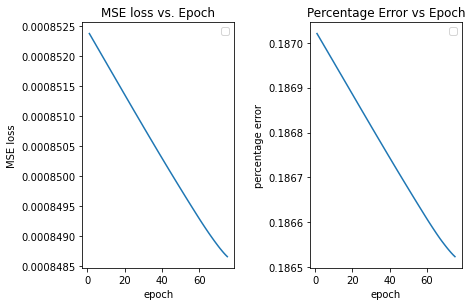

lowest MSE loss: 0.0008486519034903623 at epoch 75
lowest percentagbe error: 0.18652376580669008 at epoch 75


In [75]:
import matplotlib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()

x = []
mse = []
smape = []
current = 0
for i in tqdm(range(g_epoch)):
    current += 1
    train_model(g_train_dataset, net, 1)
    cur_mse = test_model_sme(g_test_dataset, net)
    cur_smape = test_model_smape(g_test_dataset, net)
    if (len(x) != 0):
        if (cur_mse > mse[-1]):
            break
    smape.append(cur_smape)  
    mse.append(cur_mse)
    x.append(current)
    
x = np.array(x)
mse = np.array(mse)
smape = np.array(smape)

line_1 = ax1.plot(x, mse)
line_2 = ax2.plot(x, smape)
ax1.set(xlabel="epoch", ylabel="MSE loss", title="MSE loss vs. Epoch")
ax1.legend()
ax2.set(xlabel="epoch", ylabel="percentage error", title="Percentage Error vs Epoch")
ax2.legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

print("lowest MSE loss: {} at epoch {}".format(mse[-1], x[-1]))
print("lowest percentagbe error: {} at epoch {}".format(smape[-1], x[-1]))